In [ ]:
from turtle import color
from ray.tune import ExperimentAnalysis
from matplotlib.ticker import MaxNLocator
analysis = ExperimentAnalysis("./results/temp_experiment11")
import pandas as pd
from torch import tensor
def plot(analysis, show=0):
    ax = None
    dfs = analysis.trial_dataframes
    for k, d in dfs.items():
        if "v01" in k:
            if show == 1:
                ax = d.ece.plot(ax=ax, legend=False, color="red")
            elif show == 0:
                ax = d.accuracy.plot(ax=ax, legend=False, color="red")
            else:
                ax = pd.Series([float(eval(i)) for i in d.example_loss]).plot(ax=ax, legend=False, color="red")
        else:
            if show == 1:
                ax = d.ece.plot(ax=ax, legend=False, color="blue")
            elif show == 0:
                ax = d.accuracy.plot(ax=ax, legend=False, color="blue")
            else:
                ax = pd.Series([float(eval(i)) for i in d.example_loss]).plot(ax=ax, legend=False, color="blue")
    ax.set_xlabel("Epochs")
    if show == 1:
        ax.set_ylabel("ECE")
    elif show == 0:
        ax.set_ylabel("Accuracy")
    else:
        ax.set_ylabel("Example Loss")
    # set x axis to be integers
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# show 1 for ece, 0 for accuracy, 2 for loss_example
plot(analysis, show=1)


In [1]:
from ray.tune import ExperimentAnalysis
analysis = ExperimentAnalysis("./results/temp_experiment12")
a = analysis.dataframe().sort_values("accuracy", ascending=False)
a = a.drop(columns=['timesteps_total','episodes_total', 'experiment_id','date', 'timestamp', 'pid', 
'hostname', 'node_ip','time_since_restore', 'timesteps_since_restore', 'iterations_since_restore',
'warmup_time', 'logdir', 'example_loss'])
#a[a['config/criterion']!="CrossEntropyLoss()"].sort_values("accuracy", ascending=False)
a.sort_values("accuracy", ascending=False)

,accuracy,ece,freqs,time_this_iter_s,done,training_iteration,trial_id,time_total_s,config/batch_size,config/criterion,config/eps,config/lr,config/model
7,0.8602,0.025418,"tensor([ nan, nan, nan, nan, 0.0000...",43.848557,True,200,cfc7d_00007,9606.185304,250,<function itakura_saito_loss_v01 at 0x7f2c7ff0...,0.1,0.001,<function resnet152 at 0x7f2c801f32e0>
5,0.8577,0.024778,"tensor([ nan, nan, nan, nan, 1.0000...",33.969268,True,200,cfc7d_00005,8496.506355,250,<function itakura_saito_loss_v01 at 0x7f2c7ff0...,0.1,0.001,<function resnet101 at 0x7f2c801f3130>
2,0.8458,0.033675,"tensor([ nan, nan, nan, 1.0000, 0.0000...",34.438188,True,200,cfc7d_00002,6588.288574,250,CrossEntropyLoss(),0.1,0.001,<function resnet50 at 0x7f2c801f2f80>
0,0.8407,0.037491,"tensor([ nan, nan, nan, 0.0000, 0.2632...",18.388627,True,200,cfc7d_00000,3980.207674,250,CrossEntropyLoss(),0.1,0.001,<function resnet18 at 0x7f2c801f2c20>
3,0.8345,0.029168,"tensor([ nan, nan, nan, 1.0000, 0.3333...",32.367648,True,200,cfc7d_00003,6530.904506,250,<function itakura_saito_loss_v01 at 0x7f2c7ff0...,0.1,0.001,<function resnet50 at 0x7f2c801f2f80>
1,0.8204,0.029262,"tensor([ nan, nan, nan, 0.0000, 0.0000...",19.326022,True,200,cfc7d_00001,3907.564671,250,<function itakura_saito_loss_v01 at 0x7f2c7ff0...,0.1,0.001,<function resnet18 at 0x7f2c801f2c20>
4,0.8166,0.041775,"tensor([ nan, nan, nan, nan, 0.1250...",34.044112,True,200,cfc7d_00004,8402.382345,250,CrossEntropyLoss(),0.1,0.001,<function resnet101 at 0x7f2c801f3130>
6,0.7858,0.047231,"tensor([ nan, nan, nan, nan, 0.2917...",43.006640,True,200,cfc7d_00006,9440.723209,250,CrossEntropyLoss(),0.1,0.001,<function resnet152 at 0x7f2c801f32e0>


In [ ]:
from ray.tune import ExperimentAnalysis
from tabulate import tabulate
import pandas as pd
dfs = ExperimentAnalysis("./results/temp_experiment6").trial_dataframes

n = 100
res = []
for i in range(0,n):
    ith = pd.DataFrame()
    for k, d in dfs.items():
        if len(d) < n:
            continue
        ith = pd.concat([ith, d.iloc[[i]]])
    res.append(ith)


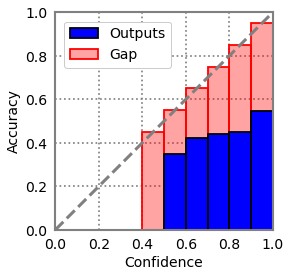

In [6]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ray.tune import ExperimentAnalysis
dfs = ExperimentAnalysis("./results/temp_experiment12").dataframe()
nan = float("nan")
freqs = eval("torch."+(dfs["freqs"][7]))
def plot_reliability(freqs):

    df = pd.DataFrame(freqs.cpu()).transpose()
    df.columns = df.columns / 10

    #ax = sns.barplot(data=df)
    plt.clf()

    main_thickness = 1.8

    # set square aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot([0,1], [0,1], color="grey", linestyle="--", linewidth=3.05, label='_nolegend_')
    # set background grey grid with dotted lines with offset
    plt.grid(color='grey', linestyle='dotted', linewidth=1, alpha=1)


    plt.bar(df.columns, 
        df.iloc[0], 
        width=0.1, 
        align="edge", 
        edgecolor="black", 
        color="blue",
        alpha=1, 
        zorder=2)
    plt.bar(df.columns,
        [n if not pd.isna(df.iloc[0].iloc[i]) else 0 for i, n in enumerate(np.arange(0.05, 1, 0.1))],
        width=0.1, 
        align="edge",
        edgecolor=matplotlib.colors.colorConverter.to_rgba('red', alpha=1),
        color=matplotlib.colors.colorConverter.to_rgba('red', alpha=0.36), 
        zorder=1)
    plt.ylabel("Accuracy")
    plt.xlabel("Confidence")
    plt.ylim(0,1)
    plt.xlim(0,1)

    # set gridlines below bars (except alpha < 1)
    plt.gca().set_axisbelow(True)
    plt.rcParams.update({'font.size': 14})

    # change edge thickness
    for i, bar in enumerate(plt.gca().patches):
        bar.set_linewidth(main_thickness)
        if i <= 10:
            bar.set_linewidth(main_thickness)

    # set all axis color to grey
    plt.gca().spines["bottom"].set_color('grey')
    plt.gca().spines["top"].set_color('grey')
    plt.gca().spines["right"].set_color('grey')
    plt.gca().spines["left"].set_color('grey')

    # set axis thickness to main_thickness
    main_thickness += 0.3
    plt.gca().spines["bottom"].set_linewidth(main_thickness)
    plt.gca().spines["top"].set_linewidth(main_thickness)
    plt.gca().spines["right"].set_linewidth(main_thickness)
    plt.gca().spines["left"].set_linewidth(main_thickness)

    # set background grid thickness
    plt.grid(linewidth=1.7)


    plt.tick_params("both", length=0, pad=8)


    # add boxed legend to top left inside graph with backgroud color white
    plt.legend(["Outputs", "Gap", ], loc="upper left", bbox_to_anchor=(0.01, 0.99), frameon=True, facecolor="white", framealpha=1,)


    plt.savefig("reliability_plot.svg", format="svg")

plot_reliability(freqs)

In [10]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ray.tune import ExperimentAnalysis
dfs = ExperimentAnalysis("./results/temp_experiment12").dataframe()
dfs.drop(columns=['timesteps_total','episodes_total', 'experiment_id','date', 'timestamp', 'pid', 
'hostname', 'node_ip','time_since_restore', 'timesteps_since_restore', 'iterations_since_restore',
'warmup_time', 'logdir', 'example_loss', 'config/eps', 'config/lr', 'training_iteration', 'done', 'config/batch_size'])

,accuracy,ece,freqs,time_this_iter_s,trial_id,time_total_s,config/criterion,config/model
0,0.8407,0.037491,"tensor([ nan, nan, nan, 0.0000, 0.2632...",18.388627,cfc7d_00000,3980.207674,CrossEntropyLoss(),<function resnet18 at 0x7f2c801f2c20>
1,0.8204,0.029262,"tensor([ nan, nan, nan, 0.0000, 0.0000...",19.326022,cfc7d_00001,3907.564671,<function itakura_saito_loss_v01 at 0x7f2c7ff0...,<function resnet18 at 0x7f2c801f2c20>
2,0.8458,0.033675,"tensor([ nan, nan, nan, 1.0000, 0.0000...",34.438188,cfc7d_00002,6588.288574,CrossEntropyLoss(),<function resnet50 at 0x7f2c801f2f80>
3,0.8345,0.029168,"tensor([ nan, nan, nan, 1.0000, 0.3333...",32.367648,cfc7d_00003,6530.904506,<function itakura_saito_loss_v01 at 0x7f2c7ff0...,<function resnet50 at 0x7f2c801f2f80>
4,0.8166,0.041775,"tensor([ nan, nan, nan, nan, 0.1250...",34.044112,cfc7d_00004,8402.382345,CrossEntropyLoss(),<function resnet101 at 0x7f2c801f3130>
5,0.8577,0.024778,"tensor([ nan, nan, nan, nan, 1.0000...",33.969268,cfc7d_00005,8496.506355,<function itakura_saito_loss_v01 at 0x7f2c7ff0...,<function resnet101 at 0x7f2c801f3130>
6,0.7858,0.047231,"tensor([ nan, nan, nan, nan, 0.2917...",43.006640,cfc7d_00006,9440.723209,CrossEntropyLoss(),<function resnet152 at 0x7f2c801f32e0>
7,0.8602,0.025418,"tensor([ nan, nan, nan, nan, 0.0000...",43.848557,cfc7d_00007,9606.185304,<function itakura_saito_loss_v01 at 0x7f2c7ff0...,<function resnet152 at 0x7f2c801f32e0>


In [8]:
import library
import tune

import torch
import torch.nn as nn
import torchvision.models as models

device = "cuda"
model = models.resnet152(num_classes=10).to(device)
train_loader, test_loader = library.load_data(250)
for i in range(20):
    tune.train(model, torch.optim.Adam(model.parameters(), 0.001), library.itakura_saito_loss_v01, train_loader, device)

Files already downloaded and verified


0.4809 0.13327522575855255


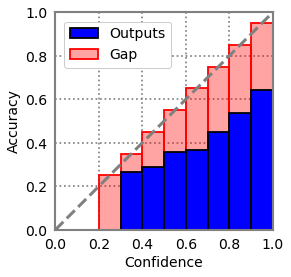

In [14]:
import importlib
importlib.reload(library)
acc, ece, freqs = library.test(model, test_loader, device, ece=True)
print(acc, ece)
plot_reliability(freqs)

In [10]:
import library
import tune

import torch
import torch.nn as nn
import torchvision.models as models

device = "cuda"
model2 = models.resnet152(num_classes=10).to(device)
train_loader, test_loader = library.load_data(250)
for i in range(20):
    tune.train(model2, torch.optim.Adam(model2.parameters(), 0.001), nn.CrossEntropyLoss(), train_loader, device)

Files already downloaded and verified


0.5298 0.05874122679233551


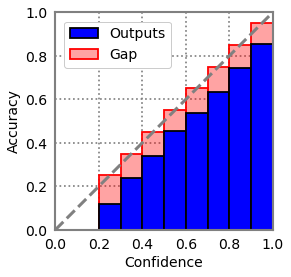

In [15]:
import importlib
importlib.reload(library)
acc, ece, freqs = library.test(model2, test_loader, device, ece=True)
print(acc, ece)
plot_reliability(freqs)